# RentalPriceModelling - Table of Contents
<a id="0"></a> <br>
In this notebook, the RentalPriceModelling for the project "Mietpreisprognose im Schweizer Wohnungsmarkt" is presented.

1. [Setup](#1)
    - [Preprocessing](#2)
    - [Encoding the Data](#3)
2. [Rental Price Modelling](#4)
    - [Narrowing the Dataset Based on Price Levels](#5)
        - [Display Price Distribution](#6)
        - [Exclude Extreme Values](#7)
    - [Model Creation](#8)
        - [Split Data and Train](#9)
        - [Multiple Linear Regression](#10)
        - [Decision Tree Regressor](#11)
        - [Random Forest Regressor](#12)
        - [XGBoost](#13)
            - [Training on all features](#14)
            - [Training on some features](#15)
    - [Evaluate Model](#16)
    - [Save Model](#17)



<a id="1"></a> 
## Setup

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

<a id="2"></a>
### Preprocessing

In [38]:
# Create Dataframe with the information from csv

df = pd.read_csv('filtered_property_location_clean.csv', delimiter=';')

#A list of columns to drop.
columns_to_drop = ['Canton','longitude','latitude','ListingId','LocationId','YearBuilt','Timestamp', 'Availability','AdditionalCost','NetPrice', 'PropertyAdditionalFeaturesId','Vendor', 'street', 'zip','PropertyDescription','bfs_number','municipality',]

#Drop column now
df= df.drop(columns=columns_to_drop)

<a id="3"></a>
### Codierung der Daten

In [39]:
# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Apply One-Hot-Encoding to the canton column

df_objectType_encoded = pd.get_dummies(df['ObjectType'])

# Explicitly convert the One-Hot-Encoding columns to int
df_objectType_encoded = df_objectType_encoded.astype(int)

# Concatenate the original DataFrame without the canton column and the result of the One-Hot-Encoding
df = pd.concat([df.drop('ObjectType', axis=1), df_objectType_encoded], axis=1)

if 'Floor' in df.columns:
    df['Floor'] = df['Floor'].replace('EG', 0)
    df['Floor'] = pd.to_numeric(df['Floor'], errors='coerce')
    # Remove rows where 'Floor' is NaN
    data = df.dropna(subset=['Floor'])
    # Filter the rows where 'Floor' is less than or equal to 10.
    rows_to_keep = data[data['Floor'] < 20]


df = rows_to_keep
    
# Delete the data with NaN values in the column 'population_density'
df = df.dropna(subset=['population_density'])

df


,Rooms,SquareMeter,Floor,Price,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,...,Loft,Maisonette / Duplex,Mansarde,Mehrfamilienhaus,Reihenfamilienhaus,Studio,Terrassenhaus,Terrassenwohnung,Villa,Wohnung
0,2.5,93.0,1.0,1920.0,97.0,77.00,97.0,77.00,468.0,1,...,0,0,0,0,0,0,0,0,0,1
1,2.5,62.0,2.0,1730.0,97.0,80.00,97.0,80.00,437.0,5,...,0,0,0,0,0,0,0,0,0,1
2,2.0,58.0,3.0,910.0,97.0,84.00,97.0,84.00,1999.0,6,...,0,0,0,0,0,0,0,0,0,1
5,3.5,80.0,2.0,2000.0,97.0,77.00,97.0,77.00,468.0,3,...,0,0,0,0,0,1,0,0,0,0
6,3.5,70.0,3.0,1290.0,97.0,78.00,97.0,78.00,826.0,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,9.5,220.0,5.0,10500.0,147.5,45.49,147.5,45.49,12811.0,19,...,0,0,0,0,0,0,0,0,0,1
8825,2.5,52.0,3.0,1770.0,147.5,45.49,147.5,45.49,12811.0,8,...,0,0,0,0,0,0,0,0,0,1
8826,2.5,52.0,3.0,1770.0,147.5,45.49,147.5,45.49,12811.0,8,...,0,0,0,0,0,0,0,0,0,1
8828,1.5,40.0,5.0,1540.0,147.5,45.49,147.5,45.49,12811.0,9,...,0,0,0,0,0,0,0,0,0,1


<a id="4"></a>
# RentalPriceModelling

<a id="5"></a>
## Narrowing the Dataset Based on Price Levels

<a id="6"></a>
### Display Price Distribution

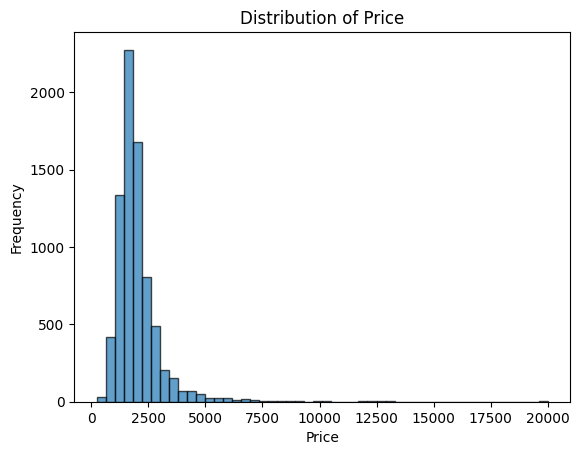

count     7729.000000
mean      2014.865183
std       1096.413875
min        250.000000
25%       1460.000000
50%       1790.000000
75%       2250.000000
max      20000.000000
Name: Price, dtype: float64


In [40]:
# Plot of the distribution of the target variable 'Price'
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Overview of the statistical metrics of the target variable
price_stats = df['Price'].describe()
print(price_stats)


<a id="7"></a>
### Exclude Extreme Values

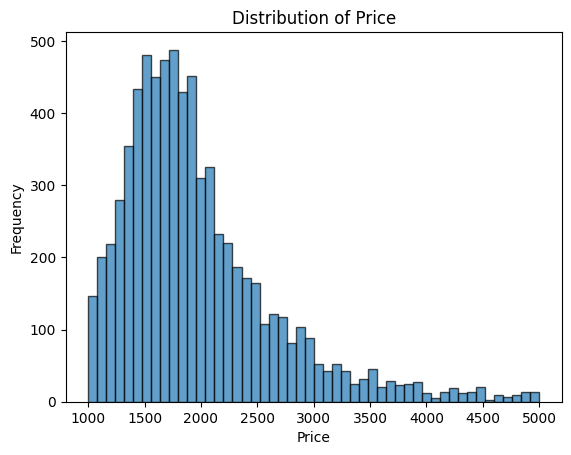

count    7199.000000
mean     1967.649535
std       683.418024
min      1000.000000
25%      1500.000000
50%      1810.000000
75%      2240.000000
max      5000.000000
Name: Price, dtype: float64


In [41]:
df = df.loc[(df['Price'] >= 1000) & 
            (df['Price'] <= 5000)]

# Plot of the distribution of the target variable 'Price'
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Overview of the statistical metrics of the target variable
price_stats = df['Price'].describe()
print(price_stats)


<a id="8"></a>
## Model creation

<a id="9"></a>
### Split data and train

In [42]:
# X (Independent variables) and y (Target variable)
X = df.drop(columns=['Price', 'Price_per_m2'])
y = df['Price'].values

# Splitting the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Save the column names
feature_names = X.columns


<a id="10"></a>
### Multiple Linear Regression

In [43]:
# Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_score = mlr.score(X_test, y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(y_test, pred_mlr)

# Extract the coefficients of the model
coefficients = mlr.coef_

# Create a DataFrame for the feature coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients and select the top 10
top_features = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10)

mlr_score


0.4855446296020154

<a id="11"></a>
### Decision Tree Regressor

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_sample

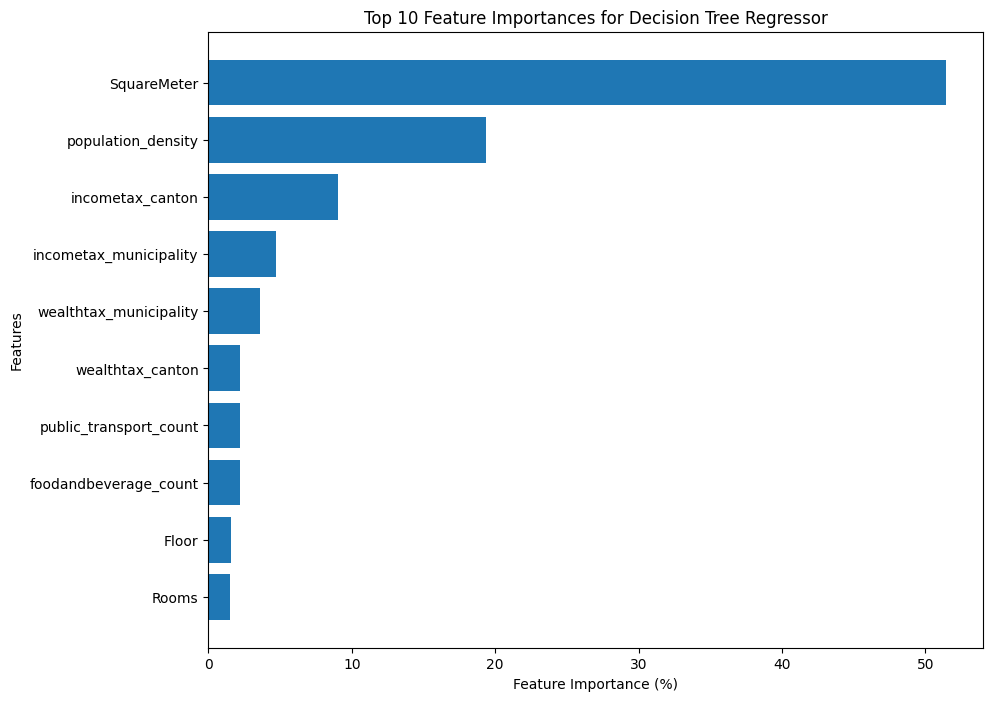

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the hyperparameters to optimize
dt_param_grid = {
    'max_depth': list(range(5, 30, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Decision Tree Regressor object
dt_regressor = DecisionTreeRegressor(random_state=0)

# Set up GridSearchCV
dt_grid_search = GridSearchCV(estimator=dt_regressor, param_grid=dt_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Train the model
dt_grid_search.fit(X_train, y_train)
dt_best_model = dt_grid_search.best_estimator_
print(f"Best parameters for DecisionTree: {dt_grid_search.best_params_}")

# Evaluate the best model
dt_best_pred = dt_best_model.predict(X_test)
dt_best_score = explained_variance_score(y_test, dt_best_pred)
print(f"Explained variance of the best DecisionTree model: {dt_best_score}")

# Feature importances for DecisionTreeRegressor
dt_importances = dt_best_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importances
})

# Sort the features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Convert importances to percentages
top_features['Importance'] = top_features['Importance'] * 100

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances for Decision Tree Regressor")
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()

# Calculate and print MSE, RMSE, MAE, and R² for the Decision Tree model
mse_best_dt = mean_squared_error(y_test, dt_best_pred)
rmse_best_dt = np.sqrt(mse_best_dt)
mae_best_dt = mean_absolute_error(y_test, dt_best_pred)
r2_best_dt = r2_score(y_test, dt_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
dtr_score = round(dt_best_model.score(X_test, y_test) * 100)


<a id="12"></a>
### Random Forest Regressor

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END

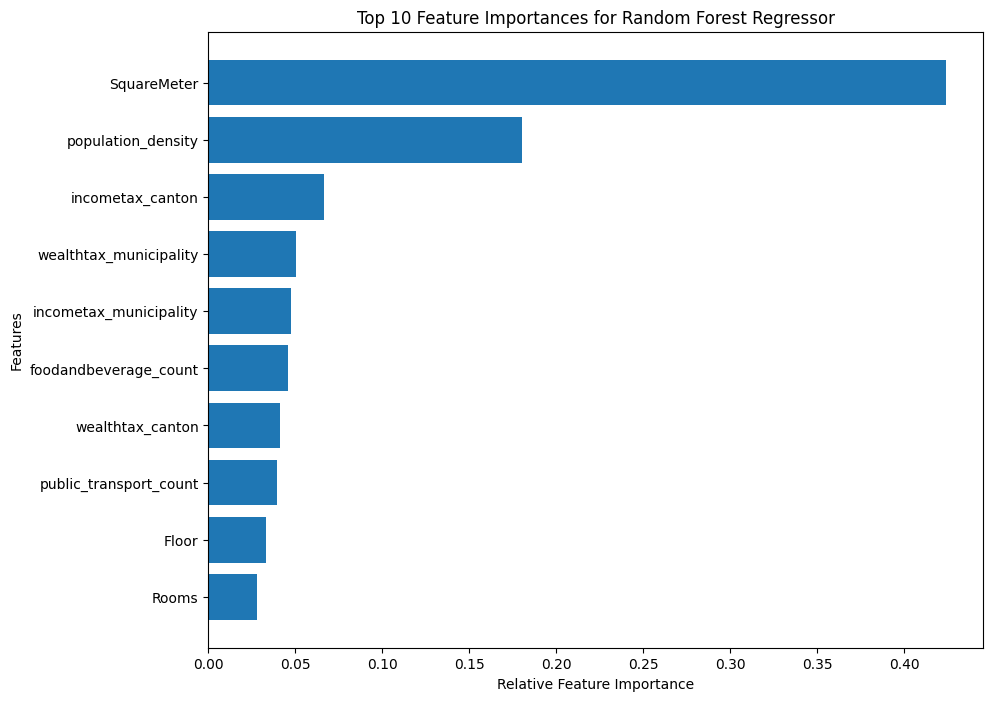

MSE: 140601.28385874644, RMSE: 374.9683771449886, MAE: 255.83620741682253, R²: 0.7046719381151434


In [45]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the hyperparameters to optimize
rf_param_grid = {
    'n_estimators': list(range(100, 600, 100)),  
    'max_depth': list(range(5, 30, 5)),  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest Regressor object
rf_regressor = RandomForestRegressor(random_state=0)

# Set up GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_regressor, param_grid=rf_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Train the model
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(f"Best parameters for RandomForest: {rf_grid_search.best_params_}")

# Evaluate the best model
rf_best_pred = rf_best_model.predict(X_test)
rf_best_score = explained_variance_score(y_test, rf_best_pred)
print(f"Explained variance of the best RandomForest model: {rf_best_score}")

forest_importances = rf_best_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': forest_importances
})

# Sort the features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Relative Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances for Random Forest Regressor")
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()

# Calculate and print MSE, RMSE, MAE, and R²
mse_best_rf = mean_squared_error(y_test, rf_best_pred)
rmse_best_rf = np.sqrt(mse_best_rf)
mae_best_rf = mean_absolute_error(y_test, rf_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)
print(f"MSE: {mse_best_rf}, RMSE: {rmse_best_rf}, MAE: {mae_best_rf}, R²: {r2_best_rf}")


<a id="13"></a>
### XGBOOST

<a id="14"></a>
#### Training on all features

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_e

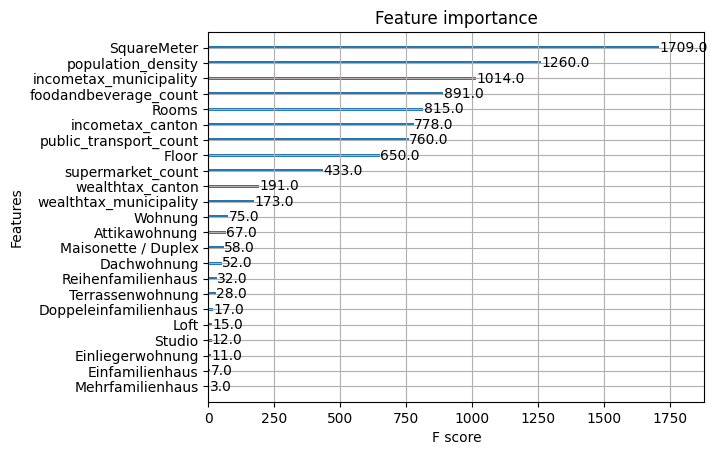

MSE: 124701.07116178365, RMSE: 353.13038832955687, MAE: 245.83246567337602, R²: 0.7380697768153119


In [46]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the hyperparameters to optimize
xgb_param_grid = {
    'n_estimators': list(range(50, 500, 50)),
    'max_depth': list(range(5, 30, 5)),
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.9],
    'gamma': [0]
}

# Create the XGBRegressor object
xgb_regressor = XGBRegressor(random_state=0)

# Set up GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=xgb_param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(r2_score))

# Train the model
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Best parameters for XGBRegressor: {xgb_grid_search.best_params_}")

# Evaluate the best model
xgb_best_pred = xgb_best_model.predict(X_test)
xgb_best_score = explained_variance_score(y_test, xgb_best_pred)
print(f"Explained variance of the best XGBRegressor model: {xgb_best_score}")

# Feature importances for XGBRegressor
xgb_importances = xgb_best_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})

# Sort the features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plot_importance(xgb_best_model)
plt.show()

# Calculate and print MSE, RMSE, MAE, and R² for the XGBoost model
mse_best_xgb = mean_squared_error(y_test, xgb_best_pred)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_xgb = r2_score(y_test, xgb_best_pred)
print(f"MSE: {mse_best_xgb}, RMSE: {rmse_best_xgb}, MAE: {mae_best_xgb}, R²: {r2_best_xgb}")


<a id="15"></a>
#### Training on some features

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_e

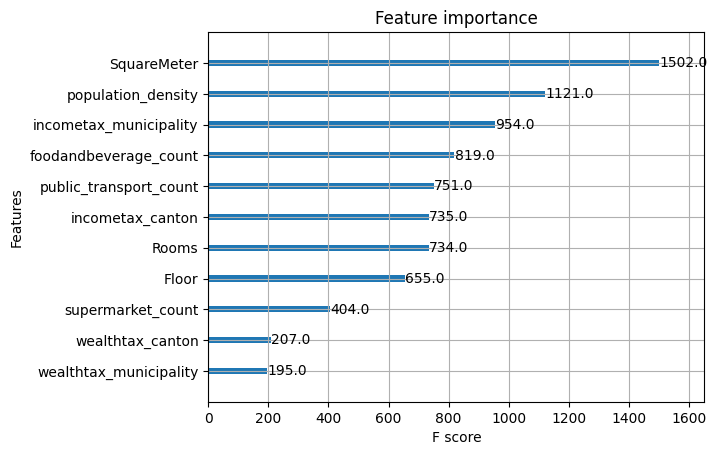

MSE: 122921.50869445599, RMSE: 350.60163817993777, MAE: 245.15311751189054, R²: 0.7418076853183871


In [47]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Remove 'ObjectType' variable and redefine X
X = df.drop(columns=['Price', 'Price_per_m2', 'Attikawohnung', 'Bauernhaus',
       'Chalet', 'Dachwohnung', 'Doppeleinfamilienhaus', 'Einfamilienhaus',
       'Einliegerwohnung', 'Loft', 'Maisonette / Duplex', 'Mansarde',
       'Mehrfamilienhaus', 'Reihenfamilienhaus', 'Studio', 'Terrassenhaus',
       'Terrassenwohnung', 'Villa', 'Wohnung'])
y = df['Price'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Save the column names
feature_names = X.columns

# Define the hyperparameters to optimize
xgb_param_grid = {
    'n_estimators': list(range(50, 500, 50)),
    'max_depth': list(range(5, 30, 5)),
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.9],
    'gamma': [0]
}

# Create the XGBRegressor object
xgb_regressor = XGBRegressor(random_state=0)

# Set up GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=xgb_param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(r2_score))

# Train the model
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Best parameters for XGBRegressor: {xgb_grid_search.best_params_}")

# Evaluate the best model
xgb_best_pred = xgb_best_model.predict(X_test)
xgb_best_score = explained_variance_score(y_test, xgb_best_pred)
print(f"Explained variance of the best XGBRegressor model: {xgb_best_score}")

# Feature importances for XGBRegressor
xgb_importances = xgb_best_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})

# Sort the features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plot_importance(xgb_best_model)
plt.show()

# Calculate and print MSE, RMSE, MAE, and R² for the XGBoost model
mse_best_xgb = mean_squared_error(y_test, xgb_best_pred)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_xgb = r2_score(y_test, xgb_best_pred)
print(f"MSE: {mse_best_xgb}, RMSE: {rmse_best_xgb}, MAE: {mae_best_xgb}, R²: {r2_best_xgb}")


<a id="16"></a>
## Evaluate model

In [48]:
# MeanSquaredError, RootMeanSquaredError and MeanAbsoluteError

expl_rf = explained_variance_score(y_test, rf_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)

# Create a ranking of the models in a table
models_score = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Mean Squared Error (MSE)': [np.round(mse_best_dt, decimals=2), np.round(mse_best_rf, decimals=2), np.round(mse_best_xgb, decimals=2)],
    'Root Mean Squared Error (RMSE)': [np.round(rmse_best_dt, decimals=2), np.round(rmse_best_rf, decimals=2), np.round(rmse_best_xgb, decimals=2)],
    'Mean Absolute Error (MAE)': [np.round(mae_best_dt, decimals=2), np.round(mae_best_rf, decimals=2), np.round(mae_best_xgb, decimals=2)],
    'R Squared (R2)': [np.round(r2_best_dt, decimals=4), np.round(r2_best_rf, decimals=4), np.round(r2_best_xgb, decimals=4)]
})

# Sort the table by the error metrics
models_score = models_score.sort_values(by=['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R Squared (R2)'], ascending=True)
models_score


,Model,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R Squared (R2)
2,XGBoost,122921.51,350.60,245.15,0.7418
1,Random Forest,140601.28,374.97,255.84,0.7047
0,Decision Tree,199240.95,446.36,309.83,0.5815


<a id="17"></a>
## Save model

In [49]:
# import joblib

# model = xgb_best_model
# ref_cols=list(X.columns)
# target = 'Price'

# joblib.dump(value=[model, ref_cols, target], filename='XGBoost_model.pkl')